In [1]:
# import ROOT
# # create a smaller events - 10k of file
# file_name='/home/prozorov/dev/star/jets_pp_2012/output/jets_embedding.root'
# tree_name = 'MatchedTree' 
# f = ROOT.TFile.Open(file_name)
# tree = f.Get(tree_name)
# # create a new file
# f_out = ROOT.TFile('jets_embedding_small.root', 'RECREATE')
# # create a new tree
# tree_out = tree.CloneTree(0)

# for i in range(20000):
#     tree.GetEntry(i)
#     # exlude mc_pt==-9 and reco_pt==-9
#     if tree.mc_pt == -9 or  tree.reco_pt == -9:
#         continue
#     # clone the entry to the new tree
#     tree_out.Fill()
# # write the new tree to the new file

# # get all keys histograms from input file
# keys = f.GetListOfKeys()
# # loop over keys and write them to the new file
# for key in keys:
#     # get the histogram
#     # skip matchedTree
#     if key.GetName() == tree_name:
#         continue
#     hist = f.Get(key.GetName())
#     f_out.cd()
#     # write the histogram to the new file
#     hist.Write()
    
# tree_out.Write()

# # close the files
# f_out.Close()

In [2]:
# import ROOT
import uproot
import pandas as pd

file_name='/home/prozorov/dev/star/jets_pp_2012/output/jets_embedding.root'
tree_name = 'MatchedTree'  # Update this to your tree name
my_file = uproot.open(file_name)
all_branches= [ 'mc_pt',
                'mc_eta',
                'mc_phi',
                'mc_neutral_fraction',
                'mc_trigger_match_JP2',
                'mc_n_constituents',
                'mc_event_id',
                'mc_weight',
                'mc_multiplicity',
                'mc_trigger_match_HT2',
                'reco_pt',
                'reco_eta',
                'reco_phi',
                'reco_neutral_fraction',
                'reco_trigger_match_JP2',
                'reco_n_constituents',
                'reco_event_id',
                'reco_weight',
                'reco_multiplicity',
                'reco_trigger_match_HT2',
                'deltaR']

selected_branches = ['mc_pt',    'mc_weight',
                     'reco_pt',  'reco_trigger_match_JP2', 'reco_trigger_match_HT2',
                    #  'mc_eta',   'mc_phi',  'deltaR'',reco_eta', 'reco_phi'
                     ]
my_tree = my_file[tree_name]
# Get the branches from the tree , limit the number of events to 100000
all_jets = my_tree.arrays(selected_branches, library='pd')#, entry_stop=10000000)
# separately have fake_jets(mc_pt=-9),  miss_jets (reco_pt=-9) and matched jets
# matched_jets= branches
# fake_jets = all_jets[all_jets['mc_pt'] == -9]
# miss_jets = all_jets[all_jets['reco_pt'] == -9]

# randomly remove 80% of jets
# all_jets = all_jets.sample(frac=0.005, random_state=1)


all_mc_jets = all_jets[all_jets['mc_pt'] != -9]
all_reco_jets = all_jets[all_jets['reco_pt'] != -9]
matched_jets = all_mc_jets[all_mc_jets['reco_pt'] != -9]

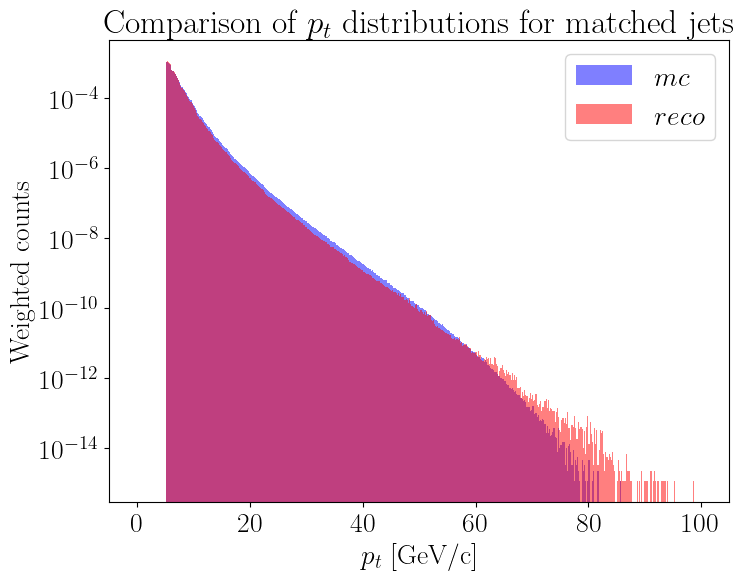

In [3]:
#  compare weighted mc_pt and reco_pt
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams

# Set the font to LaTeX
rc('font', **{'family':'serif','serif':['Computer Modern Roman'],'weight':'bold'})
rc('text', usetex=True)
# Set the font size
rcParams.update({'font.size': 20})

plt.figure(figsize=(8, 6))
plt.hist (matched_jets['mc_pt'], bins=500, range=(0, 100), alpha=0.5, label=r'$mc$', color='blue', weights=matched_jets['mc_weight'])
plt.hist (matched_jets['reco_pt'], bins=500, range=(0, 100), alpha=0.5, label=r'$reco$', color='red', weights=matched_jets['mc_weight'])
plt.xlabel(r'$p_t$ [GeV/c]')
plt.yscale('log')
plt.ylabel('Weighted counts')
plt.legend()
plt.title(r'Comparison of $p_t$ distributions for matched jets')
plt.show()

In [4]:
def plot_histogram(data, title, xlabel, ylabel, bins=200):
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=bins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # set log scale for y-axis
    plt.yscale('log')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

# # Plotting histograms for matched jets
# for branch in all_branches:
#     if branch in selected_branches:
#         print(branch)
#         data = matched_jets[branch]
#         title = f"Matched Jets: {branch}"
#         xlabel = branch
#         ylabel = "Counts"
#         plot_histogram(data, title, xlabel, ylabel)
#     else:
#         continue   

In [5]:
# plot 2d distributions of pt mc vs reco
from matplotlib.colors import LogNorm

def plot_2d_distributions(matched_jets, variables, weights, bins, ranges, cmap='Blues'):
    for var in variables:
        var_mc = f'mc_{var}'
        var_reco = f'reco_{var}'
        range_ = ranges[var]
        plt.figure(figsize=(10, 6))
        plt.hist2d(matched_jets[var_mc], matched_jets[var_reco], weights=matched_jets[weights],
                   bins=bins, norm=LogNorm(), range=range_, cmap=cmap)
        plt.colorbar(label='Counts')
        plt.xlabel(f'mc {var}')
        plt.ylabel(f'reco {var}')
        plt.title(f'2D Histogram of {var} distributions for matched jets', fontsize=20)
        plt.show()

# Define variables and ranges
variables = ['pt', 'eta', 'phi']
ranges = {
    'pt': [[0, 100], [0, 100]],
    'eta': [[-1, 1], [-1, 1]],
    'phi': [[-3.14, 3.14], [-3.14, 3.14]]
}

# Call the function
# plot_2d_distributions(matched_jets, variables, weights='mc_weight', bins=1000, ranges=ranges)


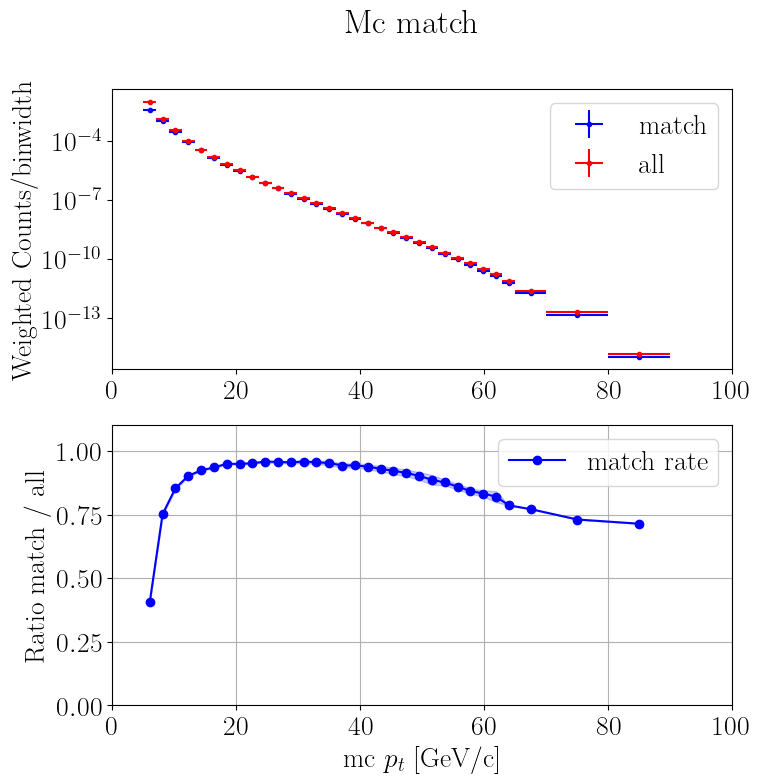

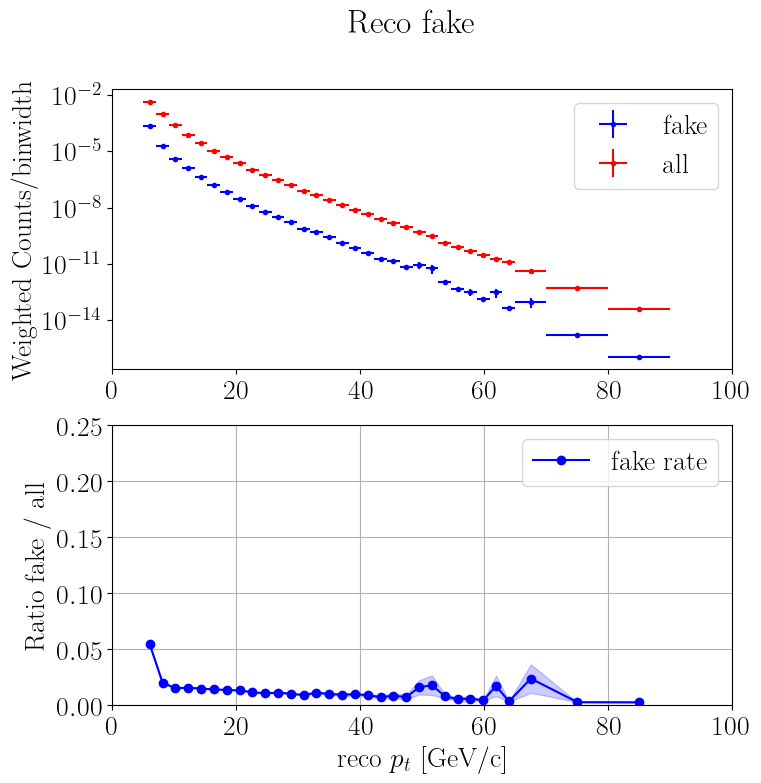

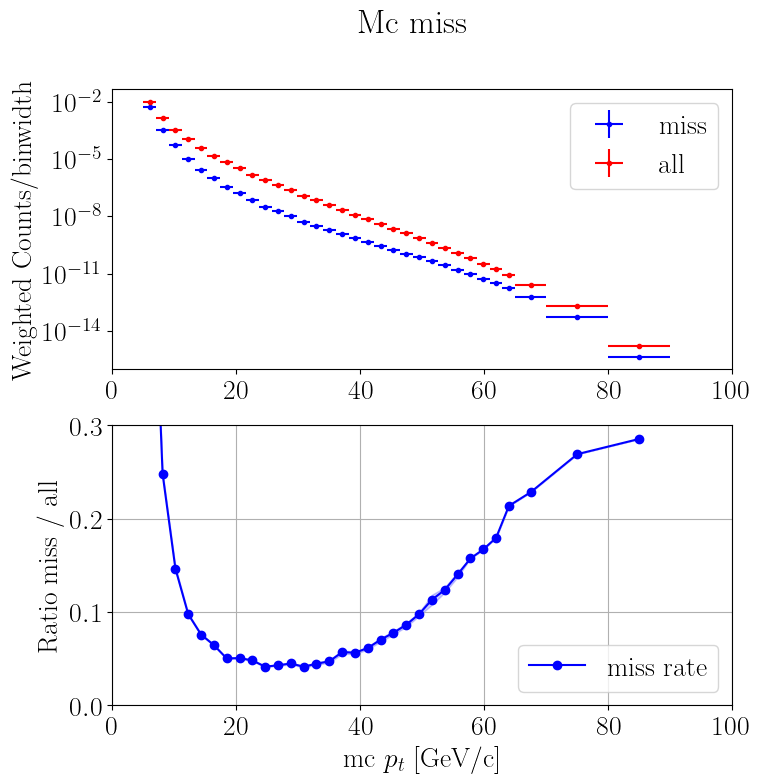

In [6]:
def plotRatio(numerator_data, denominator_data,  hist_name, column):
    """
    Plots the ratio of numerator_data to denominator_data for the given type ('reco' or 'mc').

    Args:
        numerator_data (pd.Series): Data for the numerator.
        denominator_data (pd.Series): Data for the denominator.
        hist_name (str): hist_Name of the plot (e.g., 'miss', 'fake', etc.).
        column (str):   Column hist_name to plot (e.g., 'reco', 'mc').
    """
    bins=np.linspace(5, 65, 30)
    bins = np.append(bins, [70, 80, 90])


    bin_centers = (bins[:-1] + bins[1:]) / 2
    # # Compute numerator and denominator histograms
    numerator, _ = np.histogram(numerator_data[column+'_pt'], bins=bins, weights=numerator_data['mc_weight'])
    denominator, _ = np.histogram(denominator_data[column+'_pt'], bins=bins, weights=denominator_data['mc_weight'])
    # calculate weighted errors in bins
    numerator_err= np.sqrt(np.histogram(numerator_data[column+'_pt'], bins=bins, weights=numerator_data['mc_weight']**2)[0])
    denominator_err= np.sqrt(np.histogram(denominator_data[column+'_pt'], bins=bins, weights=denominator_data['mc_weight']**2)[0])

    # normalize the histograms by bin width
    bin_widths = np.diff(bins)
    numerator = numerator / bin_widths
    denominator = denominator / bin_widths
    numerator_err = numerator_err / bin_widths
    denominator_err = denominator_err / bin_widths

    ##  without weights
    # numerator, _ = np.histogram(numerator_data[column+'_pt'], bins=bins)
    # denominator, _ = np.histogram(denominator_data[column+'_pt'], bins=bins)
    # numerator_err= np.sqrt(numerator)
    # denominator_err= np.sqrt(denominator)   

    # Avoid division by zero
    ratio = np.divide(numerator, denominator, out=np.zeros_like(numerator, dtype=float), where=denominator > 0)
    # calculate the ratio error
    ratio_err = ratio * np.sqrt((numerator_err / numerator) ** 2 + (denominator_err / denominator) ** 2)
   

    # Plot the histograms and ratio
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))
    # ax1.hist(bins[:-1], bins=bins, weights=numerator, alpha=0.5, label=f'{hist_name}', color='blue')
    # plot errors
    ax1.errorbar(bin_centers, numerator,xerr=bin_widths/2, yerr=numerator_err, fmt='.', color='blue', label=f'{hist_name}')
    # ax1.hist(bins[:-1], bins=bins, weights=denominator, alpha=0.5, label='all', color='red')
    # plot errors
    ax1.errorbar(bin_centers, denominator,xerr=bin_widths/2,  yerr=denominator_err, fmt='.', color='red', label='all')
    ax1.set_yscale('log')
    ax1.set_xlim(0, 100)
    ax1.set_ylabel('Weighted Counts/binwidth')
    ax1.legend()

    ax2.plot(bin_centers, ratio, marker='o', linestyle='-', color='blue', label=f'{hist_name} rate')
    ax2.fill_between(bin_centers, ratio - ratio_err, ratio + ratio_err, color='blue', alpha=0.2)
    ax2.set_xlabel(f'{column} $p_t$ [GeV/c]')
    ax2.set_xlim(0, 100)
    ax2.set_ylabel(f'Ratio {hist_name} / all')
    ax2.set_ylim(0, 0.25 if hist_name == 'fake' else 0.3 if hist_name == 'miss' else 1.1)
    ax2.grid()
    ax2.legend()

    plt.suptitle(f'{column.capitalize()} {hist_name}')
    plt.savefig(f'./plots/embedding/{hist_name}_{column}.pdf',format="pdf", bbox_inches="tight")


# # Plotting the ratios for matched, fake, and miss jets
fake_jets = all_reco_jets[all_reco_jets['mc_pt'] == -9]
miss_jets = all_mc_jets[all_mc_jets['reco_pt'] == -9]

plotRatio(matched_jets, all_mc_jets, 'match', 'mc')
plotRatio(fake_jets, all_reco_jets, 'fake', 'reco')
plotRatio(miss_jets, all_mc_jets, 'miss', 'mc')


In [7]:
# clean memory
import gc

gc.collect()
# close all open figures

20524

In [11]:

# conver boo type to int
all_mc_jets['reco_trigger_match_JP2'] = all_mc_jets['reco_trigger_match_JP2'].astype(int)
all_mc_jets['reco_trigger_match_HT2'] = all_mc_jets['reco_trigger_match_HT2'].astype(int)

JP2_trigger_matched=all_mc_jets[all_mc_jets['reco_trigger_match_JP2'] != 0]
HT2_trigger_matched=all_mc_jets[all_mc_jets['reco_trigger_match_HT2'] != 0]

# # plot the trigger efficiency for JP2
plotRatio(JP2_trigger_matched, all_mc_jets, 'JP2', 'mc')
plotRatio(JP2_trigger_matched, all_mc_jets, 'JP2', 'reco')
# # plot the trigger efficiency for HT2
plotRatio(HT2_trigger_matched, all_mc_jets, 'HT2', 'reco')
plotRatio(HT2_trigger_matched, all_mc_jets, 'HT2', 'mc')

/tmp/ipykernel_85089/1961626457.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_mc_jets['reco_trigger_match_JP2'] = all_mc_jets['reco_trigger_match_JP2'].astype(int)
/tmp/ipykernel_85089/1961626457.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_mc_jets['reco_trigger_match_HT2'] = all_mc_jets['reco_trigger_match_HT2'].astype(int)
Warning in <TAxis::TAxis::SetRangeUser>: ufirst < fXmin, fXmin is used
Warning in <TAxis::TAxis::SetRangeUser>: ulast > fXmax, fXmax is used
Warning in <TAxis::TAxi

In [ ]:
import numpy as np
import os
import ROOT
%jsroot on

ROOT.gStyle.SetOptStat(0)

def plotRatio(numerator_data, denominator_data, hist_name, column):
    """
    Plots the ratio of numerator_data to denominator_data for the given type using RDataFrame.
    Args:
        numerator_data (pd.DataFrame): Pandas DataFrame for the numerator.
        denominator_data (pd.DataFrame): Pandas DataFrame for the denominator.
        hist_name (str): hist_Name of the plot (e.g., 'miss', 'fake', etc.).
        column (str): Column hist_name to plot (e.g., 'reco', 'mc').
    """
    # Convert pandas DataFrames to RDataFrames
    rdf_numerator = ROOT.RDF.FromPandas(numerator_data)
    rdf_denominator = ROOT.RDF.FromPandas(denominator_data)
    
    # Define bins
    nbins = 30 + 2  # 30 bins from 5-65 plus 3 additional bins
    bins = np.linspace(5, 65, 30)
    bins = np.append(bins, [70, 80, 90])
    bin_array = np.array(bins, dtype='float64')
    
    # Create ROOT histograms with variable bins
    h_num = ROOT.TH1D("h_num", hist_name+"rate;p_{t} [GeV/c]; Weighted Counts/binwidth", len(bins)-1, bin_array)
    h_denom = ROOT.TH1D("h_denom",  hist_name+"rate;p_{t} [GeV/c]; Weighted Counts/binwidth", len(bins)-1, bin_array)
    
    # Enable error calculation with Sumw2
    h_num.Sumw2()
    h_denom.Sumw2()
    
    # Column names
    pt_column = f"{column}_pt"
    
    # Fill histograms using RDataFrames with weights
    num_histo = rdf_numerator.Histo1D(
        ROOT.RDF.TH1DModel(h_num),
        pt_column,
        "mc_weight"
    )
    
    denom_histo = rdf_denominator.Histo1D(
        ROOT.RDF.TH1DModel(h_denom),
        pt_column,
        "mc_weight"
    )
    
    # Get the actual TH1D objects from the RResultPtr
    num_th1 = num_histo.GetPtr()
    denom_th1 = denom_histo.GetPtr()

    # Create ratio histogram - clone from the actual TH1D
    h_ratio = num_th1.Clone("h_ratio")
    h_ratio.GetYaxis().SetTitle(f"Ratio{hist_name} / all")
    h_ratio.Divide(denom_th1)
    
    # Normalize histograms by bin width (scale)
    for i in range(1, num_histo.GetNbinsX() + 1):
        bin_width = num_histo.GetBinWidth(i)
        # Scale content and errors (errors are handled automatically because of Sumw2)
        num_histo.SetBinContent(i, num_histo.GetBinContent(i) / bin_width)
        num_histo.SetBinError(i, num_histo.GetBinError(i) / bin_width)
        denom_histo.SetBinContent(i, denom_histo.GetBinContent(i) / bin_width)
        denom_histo.SetBinError(i, denom_histo.GetBinError(i) / bin_width)
    
    # Create canvas and pads for plotting
    canvas = ROOT.TCanvas("canvas" +  hist_name + column, "canvas" + hist_name + column, 800, 600)
    canvas.Divide(1, 2)
    # Upper pad for histograms
    pad1 = canvas.cd(1)
    pad1.SetPad(0.0, 0.5, 1.0, 1.0)
    pad1.SetTopMargin(0.1)
    pad1.SetBottomMargin(0.0)
    pad1.SetLogy()
    
    # Set histogram styles
    num_histo.SetLineColor(ROOT.kBlue)
    num_histo.SetMarkerColor(ROOT.kBlue)
    num_histo.SetMarkerStyle(20)
    num_histo.SetMarkerSize(1.2)
    num_th1.GetXaxis().SetTitle("")
    num_th1.GetXaxis().SetLabelSize(0)
    num_th1.GetYaxis().SetTitle("#frac{1}{dp_{t}d#sigma_{pythia}} Counts")

    num_th1.GetYaxis().SetTitleSize(0.06)
    num_histo.SetTitle(hist_name + " rate")

    denom_histo.SetLineColor(ROOT.kRed)
    denom_histo.SetMarkerColor(ROOT.kRed)
    denom_histo.SetMarkerStyle(21)
    
    # Draw histograms
    num_histo.Draw("E1")
    denom_histo.Draw("E1 SAME")
    num_histo.GetXaxis().SetRangeUser(0, 100)
    
    # Create legend
    legend1 = ROOT.TLegend(0.7, 0.7, 0.9, 0.9)
    legend1.AddEntry(num_histo.GetPtr(), hist_name, "lep")
    legend1.AddEntry(denom_histo.GetPtr(), "all", "lep")
    legend1.Draw()
    
    # Lower pad for ratio
    pad2 = canvas.cd(2)
    pad2.SetPad(0.0, 0.0, 1.0, 0.5)
    pad2.SetTopMargin(0.0)
    pad2.SetBottomMargin(0.3)
    pad2.SetGridy()
    
     # Set ratio histogram style
    h_ratio.SetLineColor(ROOT.kBlue)
    h_ratio.SetMarkerColor(ROOT.kBlue)
    h_ratio.SetMarkerStyle(20)
    h_ratio.SetMarkerSize(1.2)
    h_ratio.SetTitle("")
    h_ratio.GetXaxis().SetTitle(f"{column}"+" p_{t} [GeV/c]")
    h_ratio.GetXaxis().SetTitleSize(0.12)
    h_ratio.GetXaxis().SetLabelSize(0.10)
    h_ratio.GetYaxis().SetTitle(f"Ratio {hist_name}/all")
    h_ratio.GetYaxis().SetTitleSize(0.06)
    h_ratio.GetYaxis().SetTitleOffset(0.3)
    h_ratio.GetYaxis().SetLabelSize(0.10)
    h_ratio.GetYaxis().SetRangeUser(0, 0.25 if hist_name == 'fake' else 0.3 if hist_name == 'miss' else 1.15)
    
    h_ratio.Draw("E1")
    h_ratio.GetXaxis().SetRangeUser(0, 100)

    # Make sure the output directory exists
    output_dir = "./plots/embedding_root"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Save as PDF
    canvas.SaveAs(f"{output_dir}/{hist_name}_{column}.pdf")
    # Additionally save as ROOT file all histograms and ratio
    output_file = ROOT.TFile(f"{output_dir}/{hist_name}_{column}.root", "RECREATE")
    num_histo.Write()
    denom_histo.Write()
    h_ratio.Write()


# # plot the trigger efficiency for JP2
plotRatio(JP2_trigger_matched, all_mc_jets, 'JP2', 'mc')
plotRatio(JP2_trigger_matched, all_mc_jets, 'JP2', 'reco')
# # # plot the trigger efficiency for HT2
plotRatio(HT2_trigger_matched, all_mc_jets, 'HT2', 'reco')
plotRatio(HT2_trigger_matched, all_mc_jets, 'HT2', 'mc')



Warning in <TAxis::TAxis::SetRangeUser>: ufirst < fXmin, fXmin is used
Warning in <TAxis::TAxis::SetRangeUser>: ulast > fXmax, fXmax is used
Warning in <TAxis::TAxis::SetRangeUser>: ufirst < fXmin, fXmin is used
Warning in <TAxis::TAxis::SetRangeUser>: ulast > fXmax, fXmax is used
Info in <TCanvas::Print>: pdf file ./plots/embedding_root/JP2_mc.pdf has been created
Warning in <TAxis::TAxis::SetRangeUser>: ufirst < fXmin, fXmin is used
Warning in <TAxis::TAxis::SetRangeUser>: ulast > fXmax, fXmax is used
Warning in <TAxis::TAxis::SetRangeUser>: ufirst < fXmin, fXmin is used
Warning in <TAxis::TAxis::SetRangeUser>: ulast > fXmax, fXmax is used
Info in <TCanvas::Print>: pdf file ./plots/embedding_root/JP2_reco.pdf has been created
Warning in <TAxis::TAxis::SetRangeUser>: ufirst < fXmin, fXmin is used
Warning in <TAxis::TAxis::SetRangeUser>: ulast > fXmax, fXmax is used
Warning in <TAxis::TAxis::SetRangeUser>: ufirst < fXmin, fXmin is used
Warning in <TAxis::TAxis::SetRangeUser>: ulast > f